In [1]:
import numpy as np

from scipy.optimize import curve_fit
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.dagcircuit import DAGCircuit, DAGNode, DAGOpNode

import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

from tqdm import tqdm

from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.circuit import Parameter

In [2]:
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.mappers.second_quantization import JordanWignerMapper


# TODO: update once FermionicOp supports Parameters. See Github Issue: https://github.com/Qiskit/qiskit-nature/issues/828
def compute_H_secondquant(tau, tau_d, num_sites, defect_locs):
    """
    Compute 1D spinless tight-binding Hamiltonian with "defective" interactions on specificed edges by first
        defining the system with a FermionicOp object followed by a JordanWigner transform.

    Args:
        tau - float; strength of hopping term between all sites except at the defect edge(s)
        tau_d - float; strength of hopping term at defect edge(s)
        num_sites - int; number of lattice sites in the 1D chain
        defect_locs - list or array of ints; index location(s) of defect edge(s). Indexed such that the left most edge is at position 0 and the rightmost is 4

    Returns:
        pauli_H - PauliSumOp; the Hamiltonian in Pauli operators
    """
    second_quant_H = 0
    for site in range(num_sites - 1):
        if site in defect_locs:
            second_quant_H += (
                FermionicOp("+_{}".format(site)) @ FermionicOp("-_{}".format(site + 1))
                + FermionicOp("+_{}".format(site + 1))
                @ FermionicOp("-_{}".format(site))
            ) * tau_d
        else:
            second_quant_H += (
                FermionicOp("+_{}".format(site)) @ FermionicOp("-_{}".format(site + 1))
                + FermionicOp("+_{}".format(site + 1))
                @ FermionicOp("-_{}".format(site))
            ) * tau
    # Transform to Pauli Operators
    jw_mapper = JordanWignerMapper
    pauli_H = JordanWignerMapper.map(jw_mapper, second_quant_H)

    return pauli_H


# Example computation
compute_H_secondquant(-1, -0.5, 5, [2])

PauliSumOp(SparsePauliOp(['IIIYY', 'IIIXX', 'IIYYI', 'IIXXI', 'IYYII', 'IXXII', 'YYIII', 'XXIII'],
              coeffs=[-0.5 +0.j, -0.5 +0.j, -0.5 +0.j, -0.5 +0.j, -0.25+0.j, -0.25+0.j,
 -0.5 +0.j, -0.5 +0.j]), coeff=1.0)

In [3]:
def compute_H(tau, tau_d, num_sites, defect_locs):
    """
    Compute 1D spinless tight-binding Hamiltonian with "defective" interactions on specificed edges

    Args:
        tau - float; strength of hopping term between all sites except at the defect edge(s)
        tau_d - float; strength of hopping term at defect edge(s)
        num_sites - int; number of lattice sites in the 1D chain
        defect_locs - list or array of ints; index location(s) of defect edge(s). Indexed such that the left most edge is at position 0 and the rightmost is 4

    Returns:
        H - SummedOp; the Hamiltonian
    """

    H = 0
    for i in range(num_sites - 1):
        if i in defect_locs:
            H += -tau_d / 2 * ((I ^ (num_sites - i - 2)) ^ (X ^ X) ^ (I ^ i))
            H += -tau_d / 2 * ((I ^ (num_sites - i - 2)) ^ (Y ^ Y) ^ (I ^ i))
        else:
            H += -tau / 2 * ((I ^ (num_sites - i - 2)) ^ (X ^ X) ^ (I ^ i))
            H += -tau / 2 * ((I ^ (num_sites - i - 2)) ^ (Y ^ Y) ^ (I ^ i))
    return H


# Example computation. This Hamiltonian is the same model we cover in the paper and will persist through the notebook.
num_sites = 5
defect_location = [2]

# Parameterized hopping strengths
tau = Parameter("τ")
tau_d = Parameter("τ_d")
H_param = compute_H(tau, tau_d, num_sites, defect_location)

# Select specific tau and tau_d values
H = H_param.bind_parameters({tau: 0.1, tau_d: 0.5})

# Print Hamiltonian operators to confirm it's what we expect
H

SummedOp([PauliOp(Pauli('IIIXX'), coeff=-0.05), PauliOp(Pauli('IIIYY'), coeff=-0.05), PauliOp(Pauli('IIXXI'), coeff=-0.05), PauliOp(Pauli('IIYYI'), coeff=-0.05), PauliOp(Pauli('IXXII'), coeff=-0.25), PauliOp(Pauli('IYYII'), coeff=-0.25), PauliOp(Pauli('XXIII'), coeff=-0.05), PauliOp(Pauli('YYIII'), coeff=-0.05)], coeff=1.0, abelian=False)

### Classical Simulation
We can now classically simulate the state evolution and measure the observables of interest.

In [4]:
def compute_U(H, t):
    U = (H * t).exp_i()
    return U

def corr_op(num_sites, site1, site2):
    corr=FermionicOp("-_"+str(site1), register_length = num_sites)@FermionicOp("-_"+str(site2), register_length = num_sites)

    jw_mapper = JordanWignerMapper
    corr_JW = [JordanWignerMapper.map(jw_mapper, corr)]

    return corr_JW

def corr_dagger_op(num_sites, site1, site2):
    corr=FermionicOp("+_"+str(site1), register_length = num_sites)@FermionicOp("+_"+str(site2), register_length = num_sites)

    jw_mapper = JordanWignerMapper
    corr_JW = [JordanWignerMapper.map(jw_mapper, corr)]

    return corr_JW

# Define a list of number operators in terms of Pauli operators
n_is = [
    1 / 2 * ((I ^ num_sites) - ((I ^ i) ^ Z ^ (I ^ (num_sites - i - 1))))
    for i in range(num_sites)
]

def exact_time_evolution(H,obseravble, initial_state, times, num_sites):
    evo_matrix = np.zeros((len(times), num_sites))
    var_matrix = np.zeros(len(times))
    for i, time in enumerate(tqdm(times)):
        for j, oi in enumerate(obseravble):
            # Compute the time evolution operator U(time) at time time
            U = compute_U(H, time)
            # Compute the evolution of the initial state
            final_state = U @ initial_state
            # Compute the expectation value n_i
            evo_matrix[i, j] = np.abs((final_state.adjoint() @ oi @ final_state).eval())
        var_matrix[i] = (
            np.abs((final_state.adjoint() @ (sum(obseravble) @ sum(obseravble)) @ final_state).eval())
            - np.abs((final_state.adjoint() @ sum(obseravble) @ final_state).eval()) ** 2
        )
    return evo_matrix, var_matrix
# Plot the time evolution
# Plot the time evolution
time_max = 4
times = np.linspace(0, time_max * np.pi, 500)
H_1 = H_param.bind_parameters({tau: 0.5, tau_d: 0.5})   
H_2 = H_param.bind_parameters({tau: 1, tau_d: 0.5})   

initial_state_1 = One ^ Zero ^ Zero ^ Zero ^ Zero
n_t05_evo_matrix_state_1, n_var_matrix = exact_time_evolution(H_1, n_is, initial_state_1, times, num_sites)
n_t1_evo_matrix_state_1, n_var_matrix = exact_time_evolution(H_2, n_is, initial_state_1, times, num_sites)

initial_state_2 = Zero ^ Zero ^ Zero ^ One ^ Zero
n_t05_evo_matrix_state_2, n_var_matrix = exact_time_evolution(H_1, n_is, initial_state_2, times, num_sites)
n_t1_evo_matrix_state_2, n_var_matrix = exact_time_evolution(H_2, n_is, initial_state_2, times, num_sites)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [01:14<00:00,  6.75it/s]


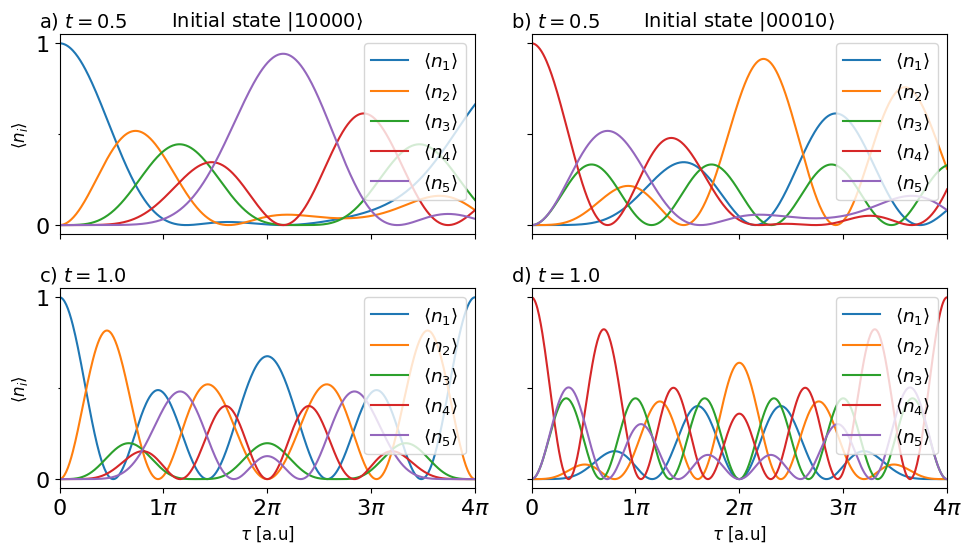

In [5]:
num_op_labels = [r"$\langle n_" + str(i+1) + r"\rangle$" for i in range(num_sites)]
xticks = np.linspace(0, time_max * np.pi, time_max+1)
xtick_labels = [r'${}\pi$'.format(i) if i != 0 else '0' for i in range(time_max+1)]
yticks = [0, 0.5, 1]
ytick_labels = ['0', '', '1'] # 0.5 tick will have no label

# --- Create 2x2 Subplot Grid ---
fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True) # Increased height slightly for legends

# --- Column 1: Initial State |100> ---
axs[0, 0].plot(times, n_t05_evo_matrix_state_1)
axs[1, 0].plot(times, n_t1_evo_matrix_state_1)
axs[0, 0].set_title(r"Initial state $|10000\rangle$", fontsize=14)

# --- Column 2: Initial State |010> ---
axs[0, 1].plot(times, n_t05_evo_matrix_state_2)
axs[1, 1].plot(times, n_t1_evo_matrix_state_2)
axs[0, 1].set_title(r"Initial state $|00010\rangle$", fontsize=14)

# --- Row, Corner, Axis Labels, and Legends ---
corner_labels = [[r'a) $t=0.5$', r'b) $t=0.5$'], [r'c) $t=1.0$', r'd) $t=1.0$']]

for r in range(2):
    # Set Y-axis label for the left column
    axs[r, 0].set_ylabel(rf"$\langle n_i \rangle$", fontsize=12)
    
    # Set X-axis label for the bottom row
    # Note: The variable 'times' is plotted on x-axis. 
    # If this label should be "Time t", please adjust.
    axs[1, r].set_xlabel(rf"$\tau$ [a.u]", fontsize=12) # Changed from tau to Time t based on plotted variable

    for c in range(2):
        # Add corner labels
        axs[r, c].text(-0.05, 1.12, corner_labels[r][c], transform=axs[r, c].transAxes,
                       fontsize=14, va='top', ha='left')
        
        # Add legend to each subplot
        # The lines from plot() are automatically picked up
        axs[r, c].legend(num_op_labels, loc='upper right', fontsize='small')

# --- General Formatting for all Subplots ---
for ax in axs.flat:
    ax.set_xlim(0, time_max * np.pi)
    ax.set_ylim(-0.05, 1.05)
    # ax.grid(linestyle='--', alpha=0.6) # Grid commented out as per your snippet
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

# Set tick labels only on the outer plots
for ax_idx, ax in enumerate(axs[1, :]):  # Bottom row
    ax.set_xticklabels(xtick_labels)
for ax_idx, ax in enumerate(axs[:, 0]):  # Left column
    ax.set_yticklabels(ytick_labels)

# --- Customize Y-Tick Length ---
default_tick_length = plt.rcParams['ytick.major.size']
for ax in axs[:, 0]: # Loop through axes in the left column
    y_major_ticks = ax.yaxis.get_major_ticks()
    for tick in y_major_ticks:
        if tick.get_loc() == 0.5:
            tick.tick1line.set_markersize(default_tick_length / 2)
            # If ticks are also on the right (twinx), you might need:
            # tick.tick2line.set_markersize(default_tick_length / 2)

# --- Final Figure Adjustments ---
# No global fig.legend() needed anymore
handles, _ = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, num_op_labels, loc='upper right', 
           bbox_to_anchor=(0.99, 0.96), frameon=False) # Add frameon=False
plt.tight_layout(rect=[0, 0.03, 1, 1])

# Save the figure (optional)
plt.savefig('figures/5-site-tb/site-prob-multi.pdf')

# --- Display the plot ---
plt.show()


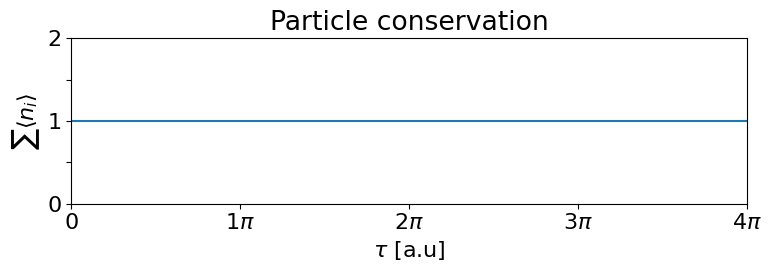

In [6]:
plt.figure(figsize=(8, 3))
plt.plot(times, np.sum(n_t05_evo_matrix_state_1, axis=1))
plt.xlabel(r"$\tau$ [a.u]")
plt.ylabel(r"$\sum \langle n_i \rangle$")
plt.title("Particle conservation")
plt.ylim([0, 2])
plt.xlim([0, time_max * np.pi])
plt.yticks([0,0.5, 1, 1.5, 2], ['0','','1', '', '2'])
plt.xticks(xticks, xtick_labels)
plt.tight_layout()
plt.savefig("figures/5-site-tb/particle-cons-check.pdf")

In [7]:
# cc_t1_evo_matrix, cc_var_matrix = exact_time_evolution(H_2, corr_op(num_sites,0,1), initial_state, times, num_sites)
# cc_dagger_t1_evo_matrix, cc_var_matrix = exact_time_evolution(H_2, corr_dagger_op(num_sites,0,1), initial_state, times, num_sites)

### Trotterization

In [8]:
from qiskit.opflow import Suzuki

def compute_U_trot(H, time, trotter_steps, order=1):
    U_trot = Suzuki(trotter_steps, order=order).convert(time * H)
    return U_trot

def trotter_evolution(H, observable, initial_state, times, num_sites, trotter_steps):
    evo_matrix_trot = np.zeros((len(times), num_sites))
    for i, time in enumerate(tqdm(times)):
        for j, oi in enumerate(observable):
            U = compute_U_trot(H, time, trotter_steps)
            final_state = U @ initial_state
            evo_matrix_trot[i, j] = np.abs(
                (final_state.adjoint() @ oi @ final_state).eval()
            )
    return evo_matrix_trot

# Time evolution calculation using same parameters as the exact classical calculation
# Initial state on the far left (same as before)
initial_state = One ^ Zero ^ Zero ^ Zero ^ Zero

# Define array of time points (technically these are relative to the hopping terms)
time_max = 8
times = np.linspace(0, time_max * np.pi, 500)

evo_matrix_trot_5 = trotter_evolution(H_2, n_is, initial_state, times, num_sites, 5)
evo_matrix_trot_8 = trotter_evolution(H_2, n_is, initial_state, times, num_sites, 8)
evo_matrix_exact, n_var_matrix = exact_time_evolution(H_2, n_is, initial_state, times, num_sites)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:35<00:00, 14.28it/s]


In [9]:
evo_matrix_exact, n_var_matrix = exact_time_evolution(H_2, n_is, initial_state, times, num_sites)

100%|██████████| 500/500 [00:36<00:00, 13.55it/s]


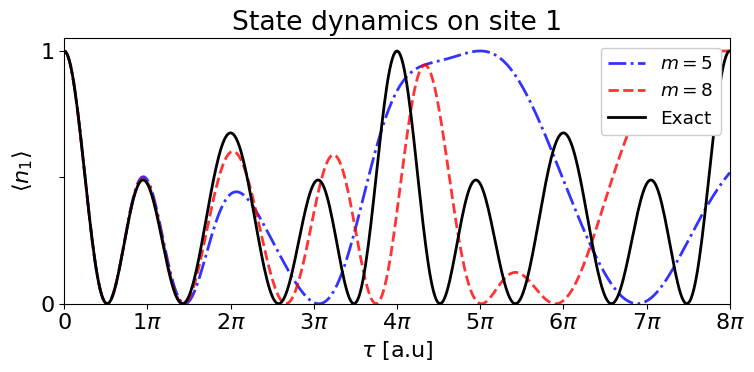

In [10]:
# Plot state dynamics over one particular site
time_max = 8

num_op_labels = [r"$\langle n_" + str(i+1) + r"\rangle$" for i in range(num_sites)]
xticks = np.linspace(0, time_max * np.pi, time_max+1)
xtick_labels = [r'${}\pi$'.format(i) if i != 0 else '0' for i in range(time_max+1)]
yticks = [0, 0.5, 1]
ytick_labels = ['0', '', '1'] # 0.5 tick will have no label

site = 0

plt.figure(figsize=(8, 4))
plt.plot(
    times,
    evo_matrix_trot_5[:, site],
    "b-.",
    linewidth=2,
    label=r"$m=5$",
    markerfacecolor="royalblue",
    alpha=0.8,
)
plt.plot(
    times,
    evo_matrix_trot_8[:, site],
    "r--",
    linewidth=2,
    label="$m=8$",
    markerfacecolor="salmon",
    alpha=0.8,
)
plt.plot(
    times, evo_matrix_exact[:, site], "k-", linewidth=2, label="Exact", markerfacecolor="grey"
)
plt.xlabel(r"$\tau$ [a.u]")
plt.ylabel(r"$\langle n_1 \rangle$")
plt.ylim([0.0, 1.05])
plt.xlim([0, time_max * np.pi])
plt.legend(loc='upper right', framealpha=1, fontsize='small')
plt.title("State dynamics on site " + str(site+1))
plt.tight_layout()
plt.yticks([0,0.5, 1], ['0','','1'])
plt.xticks(xticks, xtick_labels)
plt.savefig("figures/5-site-tb/trotter_n_site1.pdf")
plt.show()

### Draw circuit

In [11]:
from qiskit.opflow import PauliTrotterEvolution

def convert_U_trot_to_qc(U_trot):

    qc_trot = PauliTrotterEvolution().convert(U_trot)
    return (
        qc_trot.to_circuit().decompose()#.decompose()
    )  # add decompose methods so gates are not abstracted unitary blocks
    
U1 = compute_U_trot(H_2, np.pi, 1)
qc = convert_U_trot_to_qc(U1)

latex_code = qc.draw("latex_source")
print(latex_code)
with open("circuits/5-site-circuit.tex", "w") as f:
    f.write(latex_code)

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=1.0em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \qw & \qw & \qw & \qw & \qw & \qw & \multigate{1}{\mathrm{R_{YY}}\,(\mathrm{-\pi})}_<<<{0} & \multigate{1}{\mathrm{R_{XX}}\,(\mathrm{-\pi})}_<<<{0} & \qw & \qw\\
	 	\nghost{{q}_{1} :  } & \lstick{{q}_{1} :  } & \qw & \qw & \qw & \qw & \multigate{1}{\mathrm{R_{YY}}\,(\mathrm{-\pi})}_<<<{0} & \multigate{1}{\mathrm{R_{XX}}\,(\mathrm{-\pi})}_<<<{0} & \ghost{\mathrm{R_{YY}}\,(\mathrm{-\pi})}_<<<{1} & \ghost{\mathrm{R_{XX}}\,(\mathrm{-\pi})}_<<<{1} & \qw & \qw\\
	 	\nghost{{q}_{2} :  } & \lstick{{q}_{2} :  } & \qw & \qw & \multigate{1}{\mathrm{R_{YY}}\,(\mathrm{\frac{-\pi}{2}})}_<<<{0} & \multigate{1}{\mathrm{R_{XX}}\,(\mathrm{\frac{-\pi}{2}})}_<<<{0} & \ghost{\mathrm{R_{YY}}\,(\mathrm{-\pi})}_<<<{1} & \ghost{\mathrm{R_{XX}}\,(\mathrm{-\pi})}_<<<{1} & \qw & \qw & \qw & \qw\\
	 	\